In [1]:
import logging
from networkx import Graph
from numpy.random import randint

from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pandas import DataFrame

import matplotlib.pyplot as plt
from matplotlib import collections as mc
from pylab import rcParams, subplots

rcParams['figure.figsize'] = (25, 15)

In [2]:
SOURCE_PATH = '../datasets/facebook_combined.txt'

nodes = set([])
pairs = []

with open(SOURCE_PATH, 'r') as fin:
    for line in fin:
        xs = [x.strip() for x in line.split(' ')]
        nodes.update(xs)
        pairs += [xs]

# make graph, add nodes  
graph = Graph()
nodes = list(nodes)
graph.add_nodes_from(nodes)

# add edges (symmetrically)
graph.add_edges_from(pairs)
graph.add_edges_from([(y,x) for x,y in pairs])

In [3]:
def random_neighbor(x, graph=graph):
    ys = list(graph[x].keys())
    return ys[randint(low=0, high=len(ys))]

def random_chain(length, x0=None, graph=graph, nodes=nodes):
    if x0 is None:
        x0 = nodes[randint(low=0, high=len(nodes))]
    x = x0
    ys = [x0]
    for _ in range(length - 1):
        y = random_neighbor(x, graph)
        ys += [y]
        x = y
    return ys

class GraphRandomWalk(object):
    def __init__(self, n_chains, chain_len):
        self.n_chains = n_chains
        self.chain_len = chain_len
    def __iter__(self):
        for _ in range(self.n_chains - len(nodes)):
            # generate a chain
            chain = random_chain(self.chain_len)
            x0 = chain[0]
            # add prefices
            chain = ['LINK_' + y for y in chain]
            x0 = 'HEAD_' + x0
            yield LabeledSentence(words=chain, tags=[x0])
        for node in nodes:
            # generate a chain
            chain = random_chain(self.chain_len, node)
            x0 = chain[0]
            # add prefices
            chain = ['LINK_' + y for y in chain]
            x0 = 'HEAD_' + x0
            yield LabeledSentence(words=chain, tags=[x0])
            
def train_model(size, window):
    return Doc2Vec(GraphRandomWalk(1000, 100),
                   workers=5,
                   size=size, window=window, negative=8,
                   iter=10, alpha=0.1, min_count=1)           


# three models, different sizes and degrees of seperation
model_far = train_model(60, 6)
model_mid = train_model(60, 3)
model_near = train_model(60, 1)

In [7]:
prefix = 'HEAD'

keys = model_far.docvecs.doctags.keys()
keys = [k for k in keys if k[0:len(prefix)] == prefix]

pca = PCA(50)
tsne = TSNE(verbose=2)

X = np.hstack([model_far.docvecs[keys],
               model_mid.docvecs[keys],
               model_near.docvecs[keys]])
# X = model_near.docvecs[keys]
Y = pca.fit_transform(X)
Z = tsne.fit_transform(Y)

print(np.sum(pca.explained_variance_ratio_))

# plt.scatter(Z[:, 0], Z[:, 1], alpha=0.67, s = 0.5)
# plt.scatter(Z[:, 0], Z[:, 1], s = 100, c = np.array([0, 0, 1, 0.5]))
# plt.show()

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4039
[t-SNE] Computed conditional probabilities for sample 2000 / 4039
[t-SNE] Computed conditional probabilities for sample 3000 / 4039
[t-SNE] Computed conditional probabilities for sample 4000 / 4039
[t-SNE] Computed conditional probabilities for sample 4039 / 4039
[t-SNE] Mean sigma: 0.476351
[t-SNE] Iteration 25: error = 1.7129116, gradient norm = 0.0106808
[t-SNE] Iteration 50: error = 1.6390741, gradient norm = 0.0070044
[t-SNE] Iteration 75: error = 1.4675136, gradient norm = 0.0019336
[t-SNE] Iteration 100: error = 1.4405233, gradient norm = 0.0021189
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.440523
[t-SNE] Iteration 125: error = 1.3951985, gradient norm = 0.0012150
[t-SNE] Iteration 150: error = 1.3806467, gradient norm = 0.0011272
[t-SNE] Iteration 175: error = 1.3769621, gradient norm = 0.0011075
[t-SNE] I

In [8]:
df_key_x_y = (DataFrame({'key': keys,
                         'x': [Z[:, 0][keys.index(k)] for k in keys],
                         'y': [Z[:, 1][keys.index(k)] for k in keys]})
              .set_index('key'))

df_pairs = (DataFrame({'key_1': ['HEAD_' + x for x,_ in pairs],
                       'key_2': ['HEAD_' + y for _,y in pairs]})
            .join(df_key_x_y, on='key_1')
            .join(df_key_x_y, on='key_2', rsuffix='2'))


def make_line(row):
    return [(row.x, row.y), (row.x2, row.y2)]

lines = list(df_pairs.apply(make_line, 1))

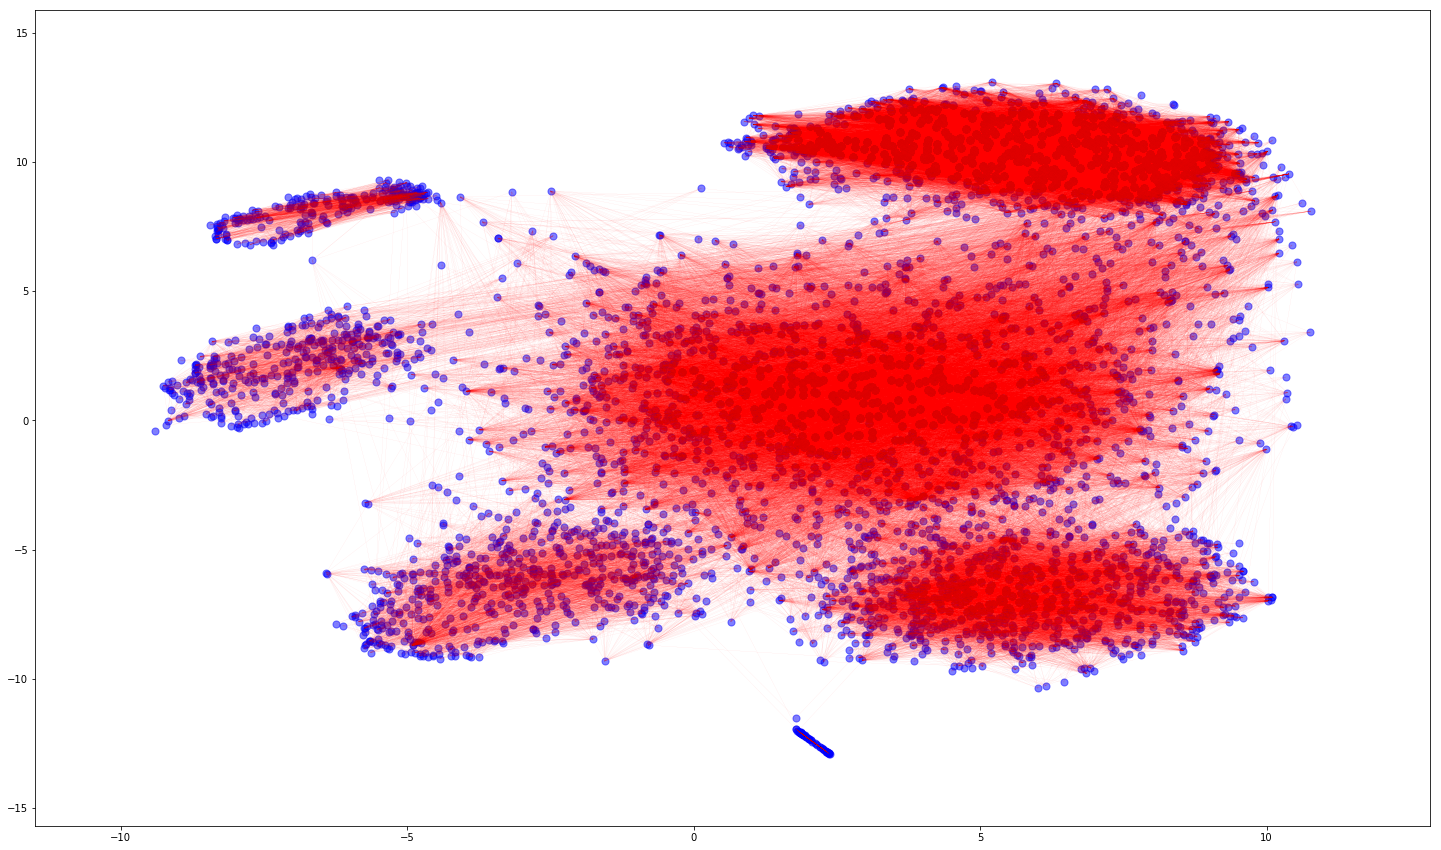

In [13]:
lc = mc.LineCollection(lines, linewidths=0.05, color = np.array([1, 0, 0, 0.5]))

fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z[:, 0], Z[:, 1], s = 50, c = np.array([0, 0, 1, 0.5]))

plt.show()